# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## План работы

1. Подготовить данные.
2. Провести исследовательский анализ данных.
3. Построить и обучить модель.

## Метрика качества

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Метрика sMAPE вычисляется так:
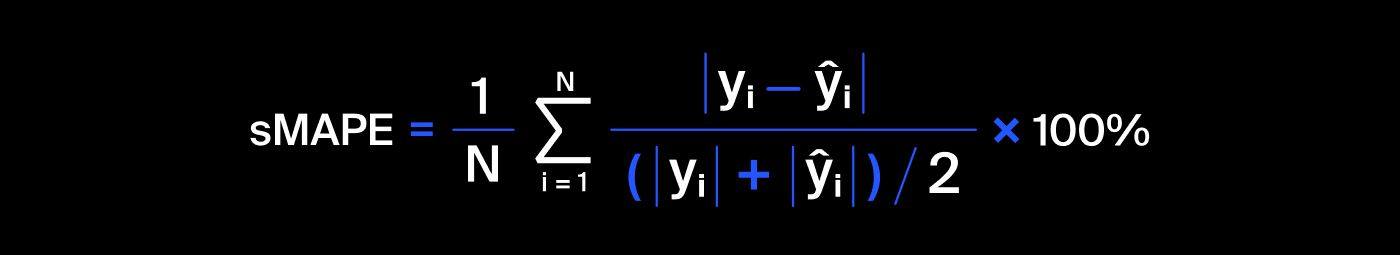

Нужно спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата rougher.output.recovery;
- эффективность обогащения финального концентрата final.output.recovery.

Итоговая метрика складывается из двух величин:
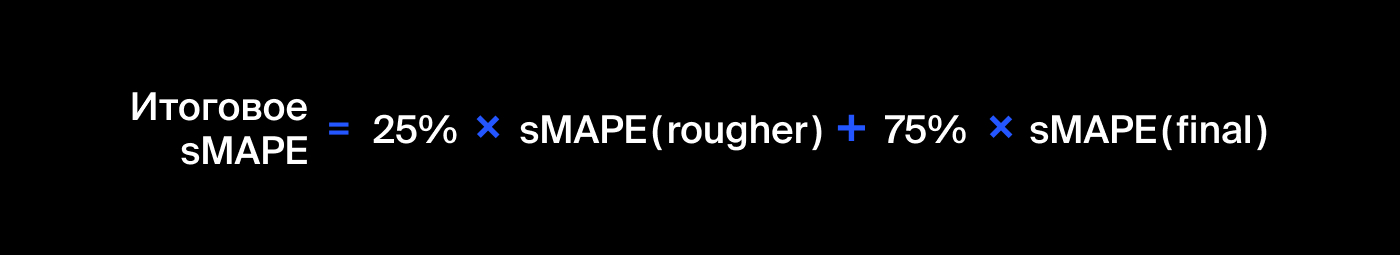

# 1. Подготовка данных

Загрузим необходимые библиотеки.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

Подключаем дата фреймы к проекту.

In [2]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [3]:
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

In [4]:
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

Изучим уникальные значения и количество пропусков в процентах.

In [5]:
def show_rows(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())
    print('Количество пропусков в каждом столбце')    
    print(data_frame.isna().mean())

In [6]:
show_rows(gold_recovery_train)

Уникальные значения столбца date
['2016-01-15 00:00:00' '2016-01-15 01:00:00' '2016-01-15 02:00:00' ...
 '2018-08-18 08:59:59' '2018-08-18 09:59:59' '2018-08-18 10:59:59']
Уникальные значения столбца final.output.concentrate_ag
[6.05540276 6.02936857 6.05592607 ... 3.10999751 3.36724104 3.59837494]
Уникальные значения столбца final.output.concentrate_pb
[ 9.88964844  9.9689441  10.21399457 ... 11.43436599 11.62558728
 11.7378318 ]
Уникальные значения столбца final.output.concentrate_sol
[5.50732422 5.25778148 5.38375877 ... 6.88601311 6.79943261 6.71750947]
Уникальные значения столбца final.output.concentrate_au
[42.19202042 42.70162925 42.65750061 ... 46.79569097 46.40818768
 46.29943814]
Уникальные значения столбца final.output.recovery
[70.54121591 69.26619763 68.11644507 ... 67.00218885 65.52324622
 70.28145415]
Уникальные значения столбца final.output.tail_ag
[10.41196156 10.46267568 10.50704594 ...  8.52960609  8.77717133
  8.40668973]
Уникальные значения столбца final.output.tai

[23.89365959 23.88952979 23.88665666 ... 29.99053346 29.96845329
 30.03186698]
Уникальные значения столбца secondary_cleaner.state.floatbank2_b_level
[-501.40628052 -500.37242843 -499.95192762 ... -611.85589811 -586.01333036
 -500.32833475]
Уникальные значения столбца secondary_cleaner.state.floatbank3_a_air
[23.96179771 23.97055025 23.91353473 ... 25.94842861 25.97173699
 26.03398999]
Уникальные значения столбца secondary_cleaner.state.floatbank3_a_level
[-495.26281738 -500.08547327 -499.44234284 ... -500.06726776 -499.60839245
 -500.14779215]
Уникальные значения столбца secondary_cleaner.state.floatbank3_b_air
[21.94040871 22.08571374 23.95771654 ... 22.96826762 22.95844822
 22.9523062 ]
Уникальные значения столбца secondary_cleaner.state.floatbank3_b_level
[-499.3409729  -499.44689706 -499.90198202 ... -499.83944174 -499.82130767
 -500.03767788]
Уникальные значения столбца secondary_cleaner.state.floatbank4_a_air
[14.01683521 13.99228103 14.01501546 ... 23.01571849 23.02496288
 23.0

In [7]:
show_rows(gold_recovery_test)

Уникальные значения столбца date
['2016-09-01 00:59:59' '2016-09-01 01:59:59' '2016-09-01 02:59:59' ...
 '2017-12-31 21:59:59' '2017-12-31 22:59:59' '2017-12-31 23:59:59']
Уникальные значения столбца primary_cleaner.input.sulfate
[210.800909   215.39245478 215.25994647 ... 171.13571781 179.6971576
 181.55685577]
Уникальные значения столбца primary_cleaner.input.depressant
[14.99311769 14.9874713  12.8849338  ... 15.99366947 15.43897911
 14.99584972]
Уникальные значения столбца primary_cleaner.input.feed_size
[8.07999992 7.78666669 7.63999987 ... 7.88999927 7.57333384 7.96666576]
Уникальные значения столбца primary_cleaner.input.xanthate
[1.00502133 0.99046929 0.99604317 ... 1.16599581 1.50106793 1.62345438]
Уникальные значения столбца primary_cleaner.state.floatbank8_a_air
[1398.98130127 1398.77791158 1398.49366613 ... 1498.83618207 1498.46624268
 1498.09630329]
Уникальные значения столбца primary_cleaner.state.floatbank8_a_level
[-500.22557739 -500.05743464 -500.86835986 ... -501.7704

In [8]:
show_rows(gold_recovery_full)

Уникальные значения столбца date
['2016-01-15 00:00:00' '2016-01-15 01:00:00' '2016-01-15 02:00:00' ...
 '2018-08-18 08:59:59' '2018-08-18 09:59:59' '2018-08-18 10:59:59']
Уникальные значения столбца final.output.concentrate_ag
[6.05540276 6.02936857 6.05592607 ... 3.10999751 3.36724104 3.59837494]
Уникальные значения столбца final.output.concentrate_pb
[ 9.88964844  9.9689441  10.21399457 ... 11.43436599 11.62558728
 11.7378318 ]
Уникальные значения столбца final.output.concentrate_sol
[5.50732422 5.25778148 5.38375877 ... 6.88601311 6.79943261 6.71750947]
Уникальные значения столбца final.output.concentrate_au
[42.19202042 42.70162925 42.65750061 ... 46.79569097 46.40818768
 46.29943814]
Уникальные значения столбца final.output.recovery
[70.54121591 69.26619763 68.11644507 ... 67.00218885 65.52324622
 70.28145415]
Уникальные значения столбца final.output.tail_ag
[10.41196156 10.46267568 10.50704594 ...  8.52960609  8.77717133
  8.40668973]
Уникальные значения столбца final.output.tai

[14.01683521 13.99228103 14.01501546 ... 23.01571849 23.02496288
 23.0186224 ]
Уникальные значения столбца secondary_cleaner.state.floatbank4_a_level
[-502.48800659 -505.50326215 -502.5209008  ... -501.71159927 -501.15340926
 -500.49270228]
Уникальные значения столбца secondary_cleaner.state.floatbank4_b_air
[12.09993076 11.95053085 11.91278306 ... 19.95123119 20.05412154
 20.02020485]
Уникальные значения столбца secondary_cleaner.state.floatbank4_b_level
[-504.71594238 -501.33152943 -501.13338307 ... -499.85702705 -500.31471091
 -500.22029567]
Уникальные значения столбца secondary_cleaner.state.floatbank5_a_air
[ 9.92563343 10.03924535 10.07091323 ... 18.01954335 17.979515
 17.96351155]
Уникальные значения столбца secondary_cleaner.state.floatbank5_a_level
[-498.31021118 -500.16998257 -500.12913456 ... -500.45115603 -499.27287133
 -499.93948991]
Уникальные значения столбца secondary_cleaner.state.floatbank5_b_air
[ 8.07966614  7.9847572   8.01387688 ... 13.02343079 12.99240352
 12.990

Рассчитаем эффективность обогащения чернового концентрата rougher.output.recovery из обучающей выборки. Предварительно удалим пропуски из столбцов со значением NaN.

In [9]:
gold_recovery_train.dropna(subset=['rougher.output.concentrate_au', 'rougher.input.feed_au',
                                   'rougher.output.tail_au','rougher.output.recovery'], inplace=True)
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14287 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  14287 non-null object
final.output.concentrate_ag                           14282 non-null float64
final.output.concentrate_pb                           14282 non-null float64
final.output.concentrate_sol                          14055 non-null float64
final.output.concentrate_au                           14283 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14287 non-null float64
final.output.tail_pb                                  14173 non-null float64
final.output.tail_sol                                 14279 non-null float64
final.output.tail_au                                  14287 non-null float64
primary_cleaner.input.sulfate                         14261 non-null float64
primary_cleaner.input.depressant             

In [10]:
concentrate_au_column = gold_recovery_train['rougher.output.concentrate_au']
feed_au_column = gold_recovery_train['rougher.input.feed_au']
tail_au_column = gold_recovery_train['rougher.output.tail_au']
input_recovery = gold_recovery_train['rougher.output.recovery']
calculated_recovery = concentrate_au_column * (feed_au_column - tail_au_column) / feed_au_column / (concentrate_au_column - tail_au_column) * 100
print('Абсолютная средняя ошибка =', mean_absolute_error(input_recovery, calculated_recovery))

Абсолютная средняя ошибка = 1.0512313043960013e-14


MAE имеет очень малое отклонение - это значит, что расчетное значение rougher.output.recovery совпадает с данными из столбца.

Проведем чистку от пропущенных значений в обучающей и тестовой выборке.

In [11]:
good_gold_recovery_train = gold_recovery_train.dropna()
good_gold_recovery_train.isna().mean()

date                                          0.0
final.output.concentrate_ag                   0.0
final.output.concentrate_pb                   0.0
final.output.concentrate_sol                  0.0
final.output.concentrate_au                   0.0
                                             ... 
secondary_cleaner.state.floatbank5_a_level    0.0
secondary_cleaner.state.floatbank5_b_air      0.0
secondary_cleaner.state.floatbank5_b_level    0.0
secondary_cleaner.state.floatbank6_a_air      0.0
secondary_cleaner.state.floatbank6_a_level    0.0
Length: 87, dtype: float64

In [12]:
good_gold_recovery_test = gold_recovery_test.dropna()
good_gold_recovery_test.isna().mean()

date                                          0.0
primary_cleaner.input.sulfate                 0.0
primary_cleaner.input.depressant              0.0
primary_cleaner.input.feed_size               0.0
primary_cleaner.input.xanthate                0.0
primary_cleaner.state.floatbank8_a_air        0.0
primary_cleaner.state.floatbank8_a_level      0.0
primary_cleaner.state.floatbank8_b_air        0.0
primary_cleaner.state.floatbank8_b_level      0.0
primary_cleaner.state.floatbank8_c_air        0.0
primary_cleaner.state.floatbank8_c_level      0.0
primary_cleaner.state.floatbank8_d_air        0.0
primary_cleaner.state.floatbank8_d_level      0.0
rougher.input.feed_ag                         0.0
rougher.input.feed_pb                         0.0
rougher.input.feed_rate                       0.0
rougher.input.feed_size                       0.0
rougher.input.feed_sol                        0.0
rougher.input.feed_au                         0.0
rougher.input.floatbank10_sulfate             0.0


В тестовой выборке отсуствуют столбцы этапов rougher.output, rougher.calculation, final.output, primary_cleaner.output и secondary_cleaner.output. Эти данные будут получены по результатам технологического процесса. Это онлайн метрики. Остальные столбцы исторически известны - значит это офлайн метрики.

Выделим столбцы из тестовой выборки, по которым будет обучаться модель. Столбец data не несет смысла для обучающей модели.
Для предсказания rougher.output.recovery будут использоватся данные из стобцов этапа rougher. Для вычисления final.output.recovery будут использованы все столбцы из тестовой выборки.

In [13]:
features_columns = good_gold_recovery_test.columns[1:]
rougher_features_columns = set(features_columns[12:34])
final_features_columns = set(features_columns)
print(rougher_features_columns)
print()
print(final_features_columns)

{'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_e_level', 'rougher.input.floatbank10_sulfate', 'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_f_level', 'rougher.state.floatbank10_e_air', 'rougher.input.feed_rate', 'rougher.input.floatbank11_sulfate', 'rougher.input.feed_size', 'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_c_air', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_b_air', 'rougher.input.feed_sol', 'rougher.state.floatbank10_a_air', 'rougher.input.floatbank11_xanthate', 'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_d_air'}

{'primary_cleaner.state.floatbank8_a_air', 'secondary_cleaner.state.floatbank4_a_level', 'primary_cleaner.input.depressant', 'secondary_cleaner.state.floatbank4_b_level', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_e_level', 'rougher.input.f

Пройдемся по ключевым столбцам в обучающей выборке.

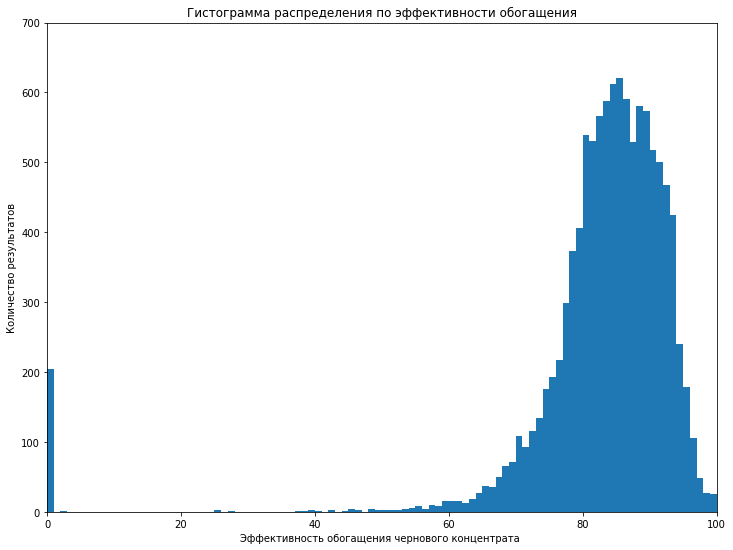

In [14]:
plt.figure(figsize=[12,9])

plt.hist(good_gold_recovery_train['rougher.output.recovery'], bins=100)

plt.xlim([0, 100])
plt.ylim([0, 700])

plt.xlabel("Эффективность обогащения чернового концентрата ")
plt.ylabel("Количество результатов")

plt.title("Гистограмма распределения по эффективности обогащения")
plt.show()

Изучим нулевые значения в столбце rougher.output.recovery.

In [15]:
good_gold_recovery_train[good_gold_recovery_train['rougher.output.recovery'] < 1].head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
45,2016-01-16 21:00:00,4.566664,10.406178,4.588698,46.614456,68.403877,10.705777,1.509070,17.875134,2.509776,...,14.025588,-550.404242,12.028925,-550.570104,10.052072,-500.797905,7.984500,-499.581046,11.982025,-599.161228
46,2016-01-16 22:00:00,4.577832,10.691605,5.274175,46.250638,70.675633,10.728531,1.641216,18.349339,2.540843,...,14.094808,-550.676337,12.004728,-550.496522,9.953139,-500.330920,8.012074,-500.133530,11.975316,-598.839683
51,2016-01-17 03:00:00,5.759800,9.537415,3.997737,45.267942,68.638723,10.623064,1.217058,16.072705,2.471388,...,14.164342,-552.959690,11.917980,-549.417320,10.016315,-497.644975,7.999080,-500.112143,12.043030,-599.630112
52,2016-01-17 04:00:00,5.807253,10.439505,6.512951,43.237493,72.136712,10.518407,1.336890,17.750367,2.323883,...,14.097072,-549.292129,12.000525,-550.306171,9.925991,-501.985618,7.948277,-500.060988,12.005620,-601.746110
836,2016-02-18 20:00:00,8.478624,11.303437,10.547473,35.776254,80.041038,12.958362,2.369492,9.839622,3.066451,...,23.709602,-412.029336,22.639733,-412.896304,25.021629,-428.537556,21.011542,-400.287375,30.004867,-396.683519


In [16]:
good_gold_recovery_train[good_gold_recovery_train['rougher.output.concentrate_au'] < 1].head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
45,2016-01-16 21:00:00,4.566664,10.406178,4.588698,46.614456,68.403877,10.705777,1.509070,17.875134,2.509776,...,14.025588,-550.404242,12.028925,-550.570104,10.052072,-500.797905,7.984500,-499.581046,11.982025,-599.161228
46,2016-01-16 22:00:00,4.577832,10.691605,5.274175,46.250638,70.675633,10.728531,1.641216,18.349339,2.540843,...,14.094808,-550.676337,12.004728,-550.496522,9.953139,-500.330920,8.012074,-500.133530,11.975316,-598.839683
51,2016-01-17 03:00:00,5.759800,9.537415,3.997737,45.267942,68.638723,10.623064,1.217058,16.072705,2.471388,...,14.164342,-552.959690,11.917980,-549.417320,10.016315,-497.644975,7.999080,-500.112143,12.043030,-599.630112
52,2016-01-17 04:00:00,5.807253,10.439505,6.512951,43.237493,72.136712,10.518407,1.336890,17.750367,2.323883,...,14.097072,-549.292129,12.000525,-550.306171,9.925991,-501.985618,7.948277,-500.060988,12.005620,-601.746110
836,2016-02-18 20:00:00,8.478624,11.303437,10.547473,35.776254,80.041038,12.958362,2.369492,9.839622,3.066451,...,23.709602,-412.029336,22.639733,-412.896304,25.021629,-428.537556,21.011542,-400.287375,30.004867,-396.683519


В данных нет информации о этапе rougher. Удалим эти значения, так как они могут исказить данные.

In [17]:
good_gold_recovery_train = good_gold_recovery_train.drop(good_gold_recovery_train[good_gold_recovery_train['rougher.output.recovery'] == 0].index)
good_gold_recovery_train[good_gold_recovery_train['rougher.output.recovery'] < 1].head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level


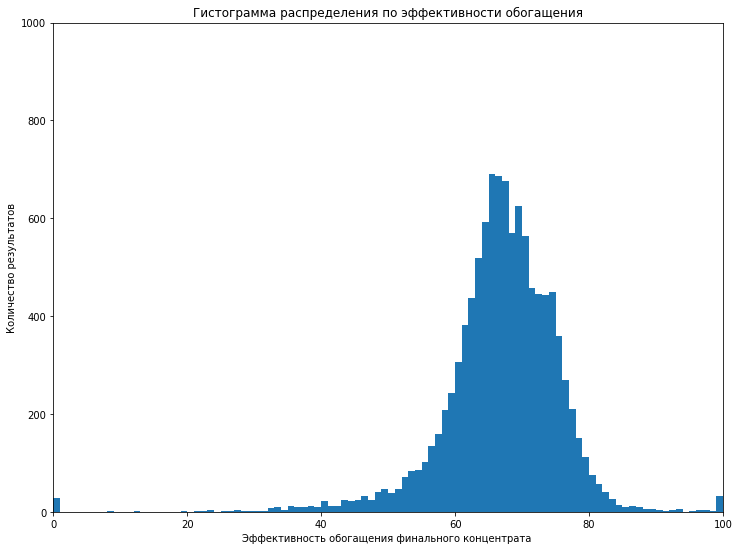

In [18]:
plt.figure(figsize=[12,9])

plt.hist(good_gold_recovery_train['final.output.recovery'], bins=100)

plt.xlim([0, 100])
plt.ylim([0, 1000])

plt.xlabel("Эффективность обогащения финального концентрата ")
plt.ylabel("Количество результатов")

plt.title("Гистограмма распределения по эффективности обогащения")
plt.show()

In [19]:
good_gold_recovery_train[good_gold_recovery_train['final.output.recovery'] < 1].head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
707,2016-02-13 11:00:00,0.0,0.0,0.0,0.0,0.0,8.894029,0.843584,15.417342,1.779052,...,21.991762,-399.587122,21.988937,-401.366408,22.995012,-399.370680,20.966863,-399.308354,24.987274,-399.619808
1354,2016-03-11 10:00:00,0.0,0.0,0.0,0.0,0.0,10.817313,1.462800,16.407607,2.984504,...,11.979352,-453.431061,12.003445,-450.179844,11.982937,-449.856468,9.927727,-450.521700,19.971682,-500.685521
1355,2016-03-11 11:00:00,0.0,0.0,0.0,0.0,0.0,10.436792,1.207636,17.800392,2.747294,...,12.034636,-446.590944,12.130405,-449.684812,11.844983,-450.881424,9.916784,-449.542871,20.004767,-500.137068
1356,2016-03-11 12:00:00,0.0,0.0,0.0,0.0,0.0,10.637073,1.405778,17.195897,2.791440,...,12.016716,-496.613149,12.055535,-496.908551,12.091144,-496.404140,9.976074,-496.783155,19.921634,-500.769011
1357,2016-03-11 13:00:00,0.0,0.0,0.0,0.0,0.0,10.530320,1.461550,17.556860,2.682127,...,11.993898,-500.427824,12.083824,-500.162537,12.078809,-499.903743,10.075259,-499.540325,20.039788,-499.932405


In [20]:
good_gold_recovery_train = good_gold_recovery_train.drop(good_gold_recovery_train[good_gold_recovery_train['final.output.recovery'] == 0].index)
good_gold_recovery_train[good_gold_recovery_train['final.output.recovery'] < 1].head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level


In [21]:
good_gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10784 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  10784 non-null object
final.output.concentrate_ag                           10784 non-null float64
final.output.concentrate_pb                           10784 non-null float64
final.output.concentrate_sol                          10784 non-null float64
final.output.concentrate_au                           10784 non-null float64
final.output.recovery                                 10784 non-null float64
final.output.tail_ag                                  10784 non-null float64
final.output.tail_pb                                  10784 non-null float64
final.output.tail_sol                                 10784 non-null float64
final.output.tail_au                                  10784 non-null float64
primary_cleaner.input.sulfate                         10784 non-null float64
primary_cleaner.input.depressant             

Проверим есть ли нулевые значения в primary_cleaner.output и secondary_cleaner.output.

In [22]:
good_gold_recovery_train[good_gold_recovery_train['primary_cleaner.output.concentrate_au'] < 1]['primary_cleaner.output.concentrate_au'].count()

109

In [23]:
good_gold_recovery_train[good_gold_recovery_train['secondary_cleaner.output.tail_au'] < 1]['secondary_cleaner.output.tail_au'].count()

426

По данным этапам тоже присутвуют нулевые значения. Но так как они не являются целью модели и не входят в список столбцов обучающей модели, оставим их без изменения.

### Вывод по шагу 1

В данных присутвовали аномалии:
- Пропущенные значение
- Нулевые значения на ключевых этапах

Неподходящие данные были удалены. Возможно не были сняты данные по выбранным этапам или они еще не были получены в результате работы системы.

Данные готовы к дальнейшему анализу.

# 2. Анализ данных

Рассмотрим концентрацию веществ на каждом этапе.

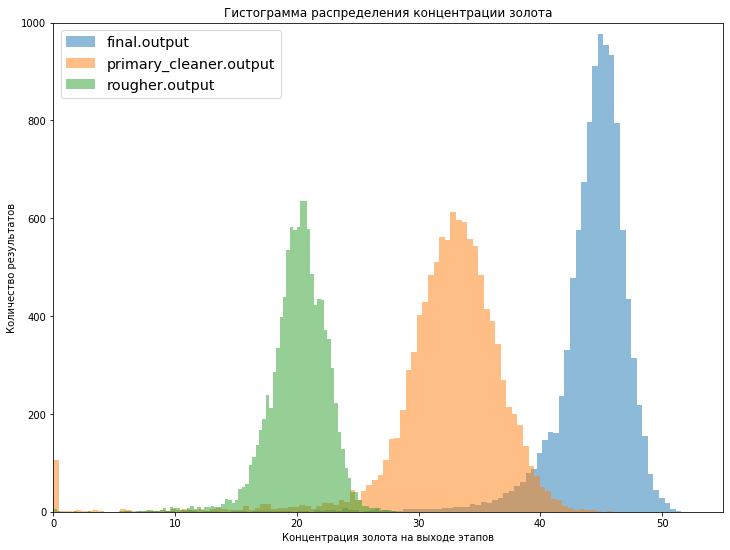

In [24]:
plt.figure(figsize=[12,9])

plt.hist(good_gold_recovery_train['final.output.concentrate_au'], bins=100, label = 'final.output', alpha=.5)
plt.hist(good_gold_recovery_train['primary_cleaner.output.concentrate_au'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(good_gold_recovery_train['rougher.output.concentrate_au'], bins=100, label = 'rougher.output', alpha=.5)

plt.xlim([0, 55])
plt.ylim([0, 1000])

plt.xlabel("Концентрация золота на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентрации золота")
plt.show()

Концентрация золота повышается с каждым этапом. Цель флотации и очисток увеличить концентрацию золота.

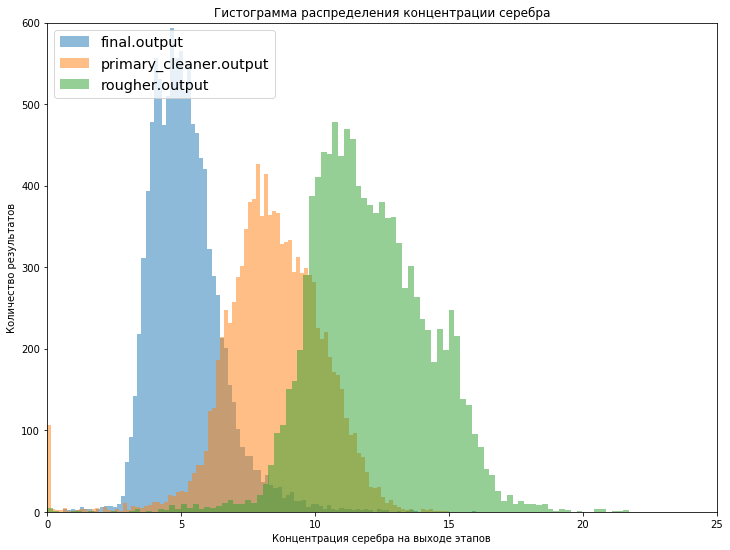

In [25]:
plt.figure(figsize=[12,9])

plt.hist(good_gold_recovery_train['final.output.concentrate_ag'], bins=100, label = 'final.output', alpha=.5)
plt.hist(good_gold_recovery_train['primary_cleaner.output.concentrate_ag'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(good_gold_recovery_train['rougher.output.concentrate_ag'], bins=100, label = 'rougher.output', alpha=.5)

plt.xlim([0, 25])
plt.ylim([0, 600])

plt.xlabel("Концентрация серебра на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентрации серебра")
plt.show()

Конецентрация серебра понижается с каждым шагом очистки. Так как основным благородным металом является золото, то остальные металлы и соединения должны быть отфильтрованы.

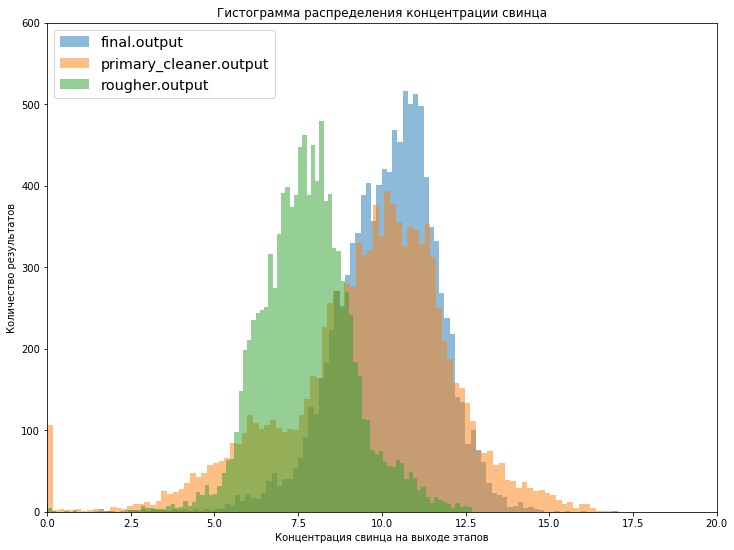

In [26]:
plt.figure(figsize=[12,9])

plt.hist(good_gold_recovery_train['final.output.concentrate_pb'], bins=100, label = 'final.output', alpha=.5)
plt.hist(good_gold_recovery_train['primary_cleaner.output.concentrate_pb'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(good_gold_recovery_train['rougher.output.concentrate_pb'], bins=100, label = 'rougher.output', alpha=.5)

plt.xlim([0, 20])
plt.ylim([0, 600])

plt.xlabel("Концентрация свинца на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентрации свинца")
plt.show()

Концентрация свинца повышается с этапа rougher до primary_cleaner. И потом усредняется. Это связано с химическим процесами очищения золота. При использование азотнокислого выщелачивания в концентрате образуется много сульфата свинца. Повышение концентрации свинца в целом происходит не только из-за этого процесса, но из-за очищения других составляющих из золотоносной руды.

Изучим размеры сырья на этапах обработки.

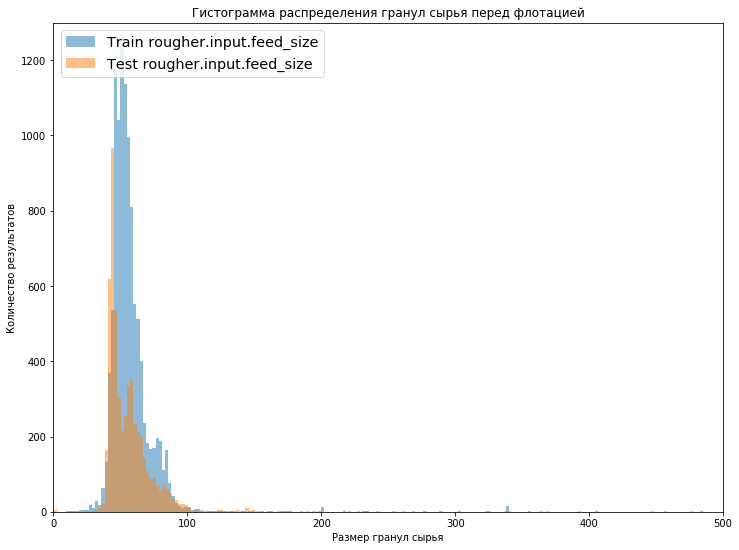

In [27]:
plt.figure(figsize=[12,9])

plt.hist(good_gold_recovery_train['rougher.input.feed_size'], bins=200, label = 'Train rougher.input.feed_size', alpha=.5)
plt.hist(good_gold_recovery_test['rougher.input.feed_size'], bins=200, label = 'Test rougher.input.feed_size', alpha=.5)

plt.xlim([0, 500])
plt.ylim([0, 1300])

plt.xlabel("Размер гранул сырья")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения гранул сырья перед флотацией")
plt.show()

Распределение гранул до флотации похоже на нормальное со смещением влево как в обучающей, так и в тестовой выбрке. Существует много выбросов после размера гранул 100.

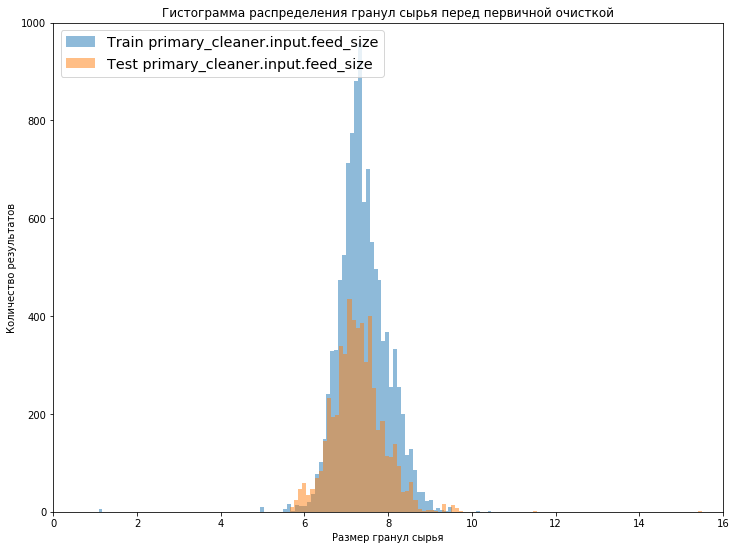

In [28]:
plt.figure(figsize=[12,9])

plt.hist(good_gold_recovery_train['primary_cleaner.input.feed_size'], bins=100, label = 'Train primary_cleaner.input.feed_size', alpha=.5)
plt.hist(good_gold_recovery_test['primary_cleaner.input.feed_size'], bins=100, label = 'Test primary_cleaner.input.feed_size', alpha=.5)

plt.xlim([0, 16])
plt.ylim([0, 1000])

plt.xlabel("Размер гранул сырья")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения гранул сырья перед первичной очисткой")
plt.show()

Размеры гранул перед первичной очисткой обладают нормальным распределением.

Подготовим столбцы с финальными концентрациями в обучающей выборке.

In [29]:
final_output_concentrate_sum_train = (good_gold_recovery_train['final.output.concentrate_au'] + 
                                      good_gold_recovery_train['final.output.concentrate_ag'] + 
                                      good_gold_recovery_train['final.output.concentrate_pb'] +
                                      good_gold_recovery_train['final.output.concentrate_sol'])
primary_cleaner_output_concentrate_sum_train = (good_gold_recovery_train['primary_cleaner.output.concentrate_au'] + 
                                                good_gold_recovery_train['primary_cleaner.output.concentrate_ag'] + 
                                                good_gold_recovery_train['primary_cleaner.output.concentrate_pb'] +
                                                good_gold_recovery_train['primary_cleaner.output.concentrate_sol'])
rougher_output_concentrate_sum_train = (good_gold_recovery_train['rougher.output.concentrate_au'] + 
                                        good_gold_recovery_train['rougher.output.concentrate_ag'] + 
                                        good_gold_recovery_train['rougher.output.concentrate_pb'] +
                                        good_gold_recovery_train['rougher.output.concentrate_sol'])

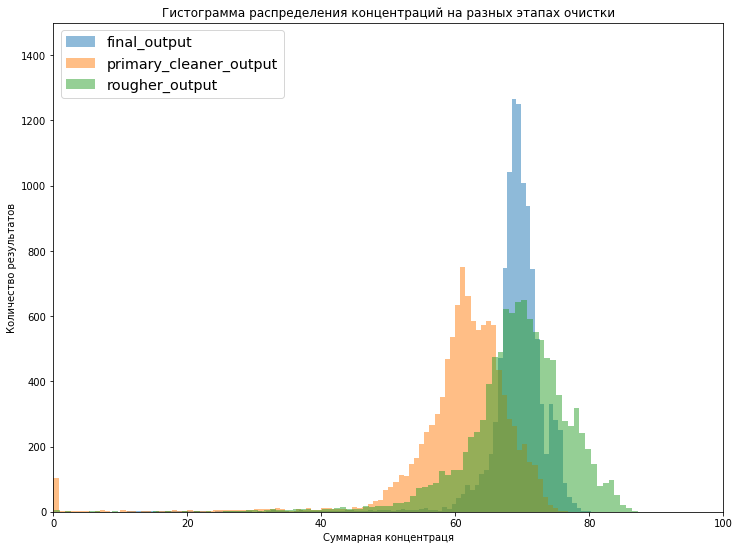

In [30]:
plt.figure(figsize=[12,9])

plt.hist(final_output_concentrate_sum_train, bins=100, label = 'final_output', alpha=.5)
plt.hist(primary_cleaner_output_concentrate_sum_train, bins=100, label = 'primary_cleaner_output', alpha=.5)
plt.hist(rougher_output_concentrate_sum_train, bins=100, label = 'rougher_output', alpha=.5)

plt.xlim([0, 100])
plt.ylim([0, 1500])

plt.xlabel("Суммарная концентраця")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентраций на разных этапах очистки")
plt.show()

По графику видно, что из аномалий много значений в 0. Приблизим график.

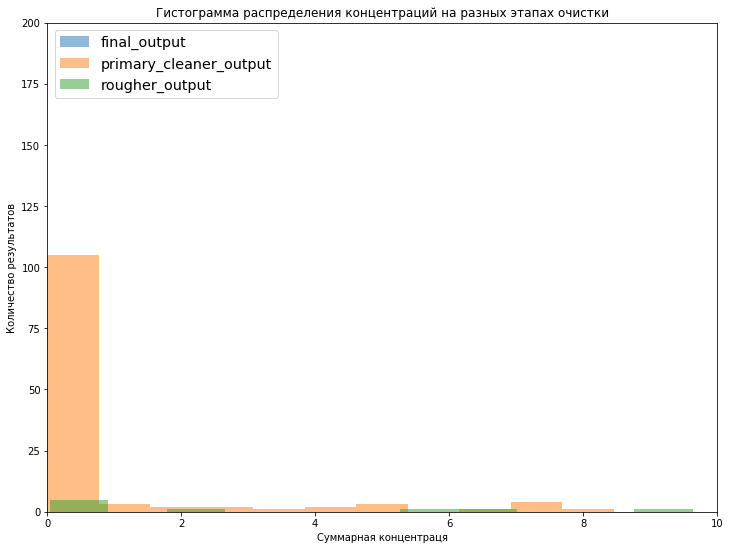

In [31]:
plt.figure(figsize=[12,9])

plt.hist(final_output_concentrate_sum_train, bins=100, label = 'final_output', alpha=.5)
plt.hist(primary_cleaner_output_concentrate_sum_train, bins=100, label = 'primary_cleaner_output', alpha=.5)
plt.hist(rougher_output_concentrate_sum_train, bins=100, label = 'rougher_output', alpha=.5)

plt.xlim([0, 10])
plt.ylim([0, 200])

plt.xlabel("Суммарная концентраця")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентраций на разных этапах очистки")
plt.show()

На этапе предобрабоки были найдены строки с нулевыми значениями в primary_cleaner.output. Эти же строки показывают суммарную концентрацию, равную 0. Соответственно они являются аномалией. Удалим их.

In [32]:
good_gold_recovery_train = good_gold_recovery_train.drop(good_gold_recovery_train[good_gold_recovery_train['primary_cleaner.output.concentrate_au'] == 0].index)
good_gold_recovery_train[good_gold_recovery_train['primary_cleaner.output.concentrate_au'] == 0].head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level


### Вывод к шагу 2

В результате анализа были изучены:
- Концетрации основных веществ на разных этапах очистки.
- Размер гранул тестовой и обучающей выборки.
- Суммарная концентрация веществ.

Аномалии были удалены. Данные готовы к обучению.

# 3. Модель

Создадим разделение признаков для предсказания rougher.output.recovery и final.output.recovery.

In [33]:
# Подготовка признаков для final.output.recovery
columns_to_delete = set(good_gold_recovery_train.columns) - final_features_columns
print(columns_to_delete)
train_features_final = good_gold_recovery_train.drop(columns_to_delete, axis=1)
print()
print(train_features_final.columns)
# Проверка вхождения всех столбцов из feateures в столбцах тестовой выборки
print(set(train_features_final.columns) - set(gold_recovery_test.columns))

# Подготовка признаков для rougher.output.recovery
columns_to_delete = set(train_features_final.columns) - rougher_features_columns
print(columns_to_delete)
train_features_rougher = train_features_final.drop(columns_to_delete, axis=1)
print()
print(train_features_rougher.columns)

{'final.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'rougher.output.tail_ag', 'secondary_cleaner.output.tail_pb', 'rougher.output.tail_pb', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.tail_ag', 'final.output.tail_pb', 'rougher.output.tail_au', 'primary_cleaner.output.tail_pb', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'final.output.tail_sol', 'rougher.output.tail_sol', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'rougher.output.concentrate_au', 'date', 'primary_cleaner.output.concentrate_sol', 'final.output.tail_au', 'final.output.concentrate_au', 'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_ag', 'final.output.recovery', 'primary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_au', 'primary_cleaner.output.tail_au

Подготовим целевой признак.

In [34]:
train_target_final = good_gold_recovery_train['final.output.recovery']
train_target_rougher = good_gold_recovery_train['rougher.output.recovery']

Подготовим признаки тестовой выборки.

In [35]:
test_features = good_gold_recovery_test.drop('date', axis=1)
test_features.columns

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

In [36]:
test_features_final = test_features
columns_to_delete = set(test_features_final.columns) - rougher_features_columns
print(columns_to_delete)
test_features_rougher = test_features_final.drop(columns_to_delete, axis=1)

{'primary_cleaner.state.floatbank8_a_air', 'secondary_cleaner.state.floatbank4_a_level', 'primary_cleaner.input.depressant', 'secondary_cleaner.state.floatbank4_b_level', 'secondary_cleaner.state.floatbank3_b_air', 'primary_cleaner.state.floatbank8_a_level', 'secondary_cleaner.state.floatbank2_a_level', 'primary_cleaner.state.floatbank8_b_level', 'secondary_cleaner.state.floatbank3_b_level', 'primary_cleaner.state.floatbank8_c_level', 'secondary_cleaner.state.floatbank3_a_level', 'primary_cleaner.state.floatbank8_c_air', 'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank2_b_air', 'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.input.sulfate', 'primary_cleaner.state.floatbank8_d_level', 'secondary_cleaner.state.floatbank5_b_level', 'secondary_cleaner.state.floatbank2_b_level', 'primary_cleaner.input.feed_size', 'secondary_cleaner.state.floatbank2_a_air', 'secondary_cleaner.state.floatbank5_a_level', 'primary_cleaner.state.floatbank8_b_air', 'primar

Функция вычисления симметричного среднего абсолютного процентного отклонения.

In [37]:
def sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted):
    n = rougher_recovery_real.shape[0]
    rougher_sMAPE = ((2*abs(rougher_recovery_real - rougher_recovery_predicted)/
                     (abs(rougher_recovery_real) + abs(rougher_recovery_predicted))).sum() * 100 / n)
    final_sMAPE = ((2*abs(final_recovery_real - final_recovery_predicted)/
                     (abs(final_recovery_real) + abs(final_recovery_predicted))).sum() * 100 / n)
    return rougher_sMAPE * 0.25 + final_sMAPE * 0.75

Перед нами стоит задача регресии. Выберем следующие модели для обучения:
- Линейная регрессия
- Полиноминальная регрессия. Применется на линейной регрессии с подготовленными признаками
- Регрессия Ridge
- DecisionTreeRegressor

Выполним поиск лучшей модели для предсказаний 

In [38]:
%%time

regressor = LinearRegression()
print('Mean R2 from CV of LinearRegression =', cross_val_score(regressor, train_features_final, train_target_final, cv=5).mean())
print('Mean MAE from CV of LinearRegression =', cross_val_score(regressor, train_features_final, train_target_final, cv=5, scoring='neg_mean_absolute_error').mean())

Mean R2 from CV of LinearRegression = -0.19455349428688645
Mean MAE from CV of LinearRegression = -5.903842205297213
CPU times: user 1.07 s, sys: 909 ms, total: 1.98 s
Wall time: 1.97 s


Проверим влияние масштаба признаков на качество модели.

In [39]:
%%time

regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
print('Mean R2 from CV of LinearRegression =', cross_val_score(pipeline, train_features_final, train_target_final, cv=5).mean())
print('Mean MAE from CV of LinearRegression =', cross_val_score(pipeline, train_features_final, train_target_final, cv=5, scoring='neg_mean_absolute_error').mean())

Mean R2 from CV of LinearRegression = -0.19455349428688687
Mean MAE from CV of LinearRegression = -5.9038422052972095
CPU times: user 1.61 s, sys: 1.27 s, total: 2.88 s
Wall time: 2.9 s


Масштаб признаков не влияет.

In [40]:
%%time

regressor = LinearRegression()
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
pipeline = Pipeline([("polynomial_features", polynomial_features),("linear_regression", regressor)])
print('Mean R2 from CV of PolynomialRegression with 2 degree =', cross_val_score(pipeline, train_features_final, train_target_final, cv=5).mean())
print('Mean MAE from CV of PolynomialRegression with 2 degree =', cross_val_score(pipeline, train_features_final, train_target_final, cv=5, scoring='neg_mean_absolute_error').mean())

Mean R2 from CV of PolynomialRegression with 2 degree = -53.89653174444648
Mean MAE from CV of PolynomialRegression with 2 degree = -31.7011974360758
CPU times: user 1min 58s, sys: 1min 16s, total: 3min 15s
Wall time: 3min 16s


Для регрессоров Ridge и DecisionTreeRegressor применим метод GridSearchCV. В нем уже вложена кросс-валидация.

In [41]:
%%time

regressor = Ridge()
hyperparams = [{'alpha':[0.1, 1, 10, 100], 'solver':['auto']},
                 {'alpha':[0.1, 1, 10, 100], 'solver':['svd']}, 
                 {'alpha':[0.1, 1, 10, 100], 'solver':['cholesky']},
                 {'alpha':[0.1, 1, 10, 100], 'solver':['lsqr']}, 
                 {'alpha':[0.1, 1, 10, 100], 'solver':['sparse_cg']}]

scores = ['r2', 'neg_mean_absolute_error']

for score in scores:
    print('# Tuning hyper-parameters for %s' % score)
    print()
    clf = GridSearchCV(regressor, hyperparams, scoring=score)
    clf.fit(train_features_final, train_target_final)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    print()


# Tuning hyper-parameters for r2

Best parameters set found on development set:

{'alpha': 100, 'solver': 'sparse_cg'}

Grid scores on development set:

-0.236 (+/-0.480) for {'alpha': 0.1, 'solver': 'auto'}
-0.235 (+/-0.480) for {'alpha': 1, 'solver': 'auto'}
-0.235 (+/-0.484) for {'alpha': 10, 'solver': 'auto'}
-0.224 (+/-0.497) for {'alpha': 100, 'solver': 'auto'}
-0.236 (+/-0.480) for {'alpha': 0.1, 'solver': 'svd'}
-0.235 (+/-0.480) for {'alpha': 1, 'solver': 'svd'}
-0.235 (+/-0.484) for {'alpha': 10, 'solver': 'svd'}
-0.224 (+/-0.497) for {'alpha': 100, 'solver': 'svd'}
-0.236 (+/-0.480) for {'alpha': 0.1, 'solver': 'cholesky'}
-0.235 (+/-0.480) for {'alpha': 1, 'solver': 'cholesky'}
-0.235 (+/-0.484) for {'alpha': 10, 'solver': 'cholesky'}
-0.224 (+/-0.497) for {'alpha': 100, 'solver': 'cholesky'}
-0.470 (+/-0.716) for {'alpha': 0.1, 'solver': 'lsqr'}
-0.470 (+/-0.716) for {'alpha': 1, 'solver': 'lsqr'}
-0.470 (+/-0.716) for {'alpha': 10, 'solver': 'lsqr'}
-0.470 (+/-0.716) for 

In [42]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 21, 2)]
hyperparams = [{'criterion':['mse'], 'max_depth':max_depth_list, 'random_state':[15062020]},
               {'criterion':['mae'], 'max_depth':max_depth_list, 'random_state':[15062020]}]

print('# Tuning hyper-parameters')
print()
clf = GridSearchCV(regressor, hyperparams)
clf.fit(train_features_final, train_target_final)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
print()

# Tuning hyper-parameters

Best parameters set found on development set:

{'criterion': 'mae', 'max_depth': 2, 'random_state': 15062020}

Grid scores on development set:

-0.134 (+/-0.286) for {'criterion': 'mse', 'max_depth': 2, 'random_state': 15062020}
-0.055 (+/-0.188) for {'criterion': 'mse', 'max_depth': 4, 'random_state': 15062020}
-0.260 (+/-0.131) for {'criterion': 'mse', 'max_depth': 6, 'random_state': 15062020}
-0.435 (+/-0.091) for {'criterion': 'mse', 'max_depth': 8, 'random_state': 15062020}
-0.878 (+/-0.074) for {'criterion': 'mse', 'max_depth': 10, 'random_state': 15062020}
-0.890 (+/-0.322) for {'criterion': 'mse', 'max_depth': 12, 'random_state': 15062020}
-1.023 (+/-0.408) for {'criterion': 'mse', 'max_depth': 14, 'random_state': 15062020}
-1.160 (+/-0.837) for {'criterion': 'mse', 'max_depth': 16, 'random_state': 15062020}
-1.398 (+/-1.096) for {'criterion': 'mse', 'max_depth': 18, 'random_state': 15062020}
-1.364 (+/-0.945) for {'criterion': 'mse', 'max_depth': 20,

Проверим лучшие модели по метрикам на созданной метрике sMAPE. Проверим реальные данные.

In [43]:
rougher_recovery_real = gold_recovery_full.loc[test_features_rougher.index,'rougher.output.recovery']
final_recovery_real = gold_recovery_full.loc[test_features_final.index,'final.output.recovery']
print('Процент пропусков в общей выборке' ,rougher_recovery_real.isna().mean())
print('Процент пропусков в общей выборке',final_recovery_real.isna().mean())

Процент пропусков в общей выборке 0.14397176295745867
Процент пропусков в общей выборке 0.10477428942968604


В реальной таблице отсутсвуют зачения для выборки. Они будут игнорироваться при расчете sMAPE.

In [44]:
%%time

model = LinearRegression()
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('sMAPE для линейной регресии',sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

regressor = LinearRegression()
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
model = Pipeline([("polynomial_features", polynomial_features),("linear_regression", regressor)])
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('sMAPE для полиноминальной регресии',sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

model = Ridge(alpha=100, solver='sparse_cg')
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('sMAPE для регресии Ridge',sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

model = DecisionTreeRegressor(criterion='mae', max_depth=2, random_state=15062020)
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('sMAPE для DecisionTreeRegressor',sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))  

sMAPE для линейной регресии 12.300567079496306
sMAPE для полиноминальной регресии 25.250639724184683
sMAPE для регресии Ridge 12.26722074050842
sMAPE для DecisionTreeRegressor 12.397228650408637
CPU times: user 1min 5s, sys: 0 ns, total: 1min 5s
Wall time: 1min 7s


Создадим константную модель на медианных значений. Изменим код функции для подсчета.

In [45]:
median_rougher_recovery = gold_recovery_full['rougher.output.recovery'].median()
median_final_recovery = gold_recovery_full['final.output.recovery'].median()

n = rougher_recovery_real.shape[0]
rougher_sMAPE = ((2*abs(rougher_recovery_real - median_rougher_recovery)/
                     (abs(rougher_recovery_real) + abs(median_rougher_recovery))).sum() * 100 / n)
final_sMAPE = ((2*abs(final_recovery_real - median_final_recovery)/
                     (abs(final_recovery_real) + abs(median_final_recovery))).sum() * 100 / n)
print('sMAPE для медианной константной модели', rougher_sMAPE * 0.25 + final_sMAPE * 0.75)

sMAPE для медианной константной модели 11.437793816641223


Проведем сокращение тестовой выборки из-за пропущенных значений rougher.output.recovery и final.output.recovery в полном датафрейме. Для вычисления sMAPE длина и индексы всех серий должны быть одинаковы.

In [46]:
rougher_recovery_real.dropna(inplace=True)
print('Количество строк rougher_recovery_real =', rougher_recovery_real.shape[0])
final_recovery_real.dropna(inplace=True)
print('Количество строк final_recovery_real =', final_recovery_real.shape[0])
print('Количество строк test_features_rougher =', test_features_rougher.shape[0])

not_nan_index = set(test_features_rougher.index)
not_nan_index = not_nan_index.intersection(set(final_recovery_real.index), set(rougher_recovery_real.index))
print('Количество индексов с полными данными=', len(not_nan_index))

Количество строк rougher_recovery_real = 4608
Количество строк final_recovery_real = 4819
Количество строк test_features_rougher = 5383
Количество индексов с полными данными= 4554


Преобразем количество данных тестовой выбоки и рельных так, чтобы не было NaN.

In [47]:
rougher_recovery_real = gold_recovery_full.loc[not_nan_index,'rougher.output.recovery']
final_recovery_real = gold_recovery_full.loc[not_nan_index,'final.output.recovery']
test_features_rougher = test_features_rougher.loc[not_nan_index,:]
test_features_final = test_features_final.loc[not_nan_index,:]
print('Количество строк test_features_final =', test_features_final.shape[0])

Количество строк test_features_final = 4554


Повторим получение sMAPE на тех же моделях.

In [48]:
%%time

model = LinearRegression()
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('sMAPE для линейной регресии',sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

regressor = LinearRegression()
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
model = Pipeline([("polynomial_features", polynomial_features),("linear_regression", regressor)])
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('sMAPE для полиноминальной регресии',sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

model = Ridge(alpha=100, solver='sparse_cg')
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('sMAPE для регресии Ridge',sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

model = DecisionTreeRegressor(criterion='mae', max_depth=2, random_state=15062020)
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('sMAPE для DecisionTreeRegressor',sMAPE_score(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted)) 

n = rougher_recovery_real.shape[0]
rougher_sMAPE = ((2*abs(rougher_recovery_real - median_rougher_recovery)/
                     (abs(rougher_recovery_real) + abs(median_rougher_recovery))).sum() * 100 / n)
final_sMAPE = ((2*abs(final_recovery_real - median_final_recovery)/
                     (abs(final_recovery_real) + abs(median_final_recovery))).sum() * 100 / n)
print('sMAPE для медианной константной модели', rougher_sMAPE * 0.25 + final_sMAPE * 0.75)

sMAPE для линейной регресии 13.212153673716113
sMAPE для полиноминальной регресии 27.988194717599818
sMAPE для регресии Ridge 13.18546815084092
sMAPE для DecisionTreeRegressor 13.296719085879957
sMAPE для медианной константной модели 12.236756621839444
CPU times: user 59.9 s, sys: 6.6 s, total: 1min 6s
Wall time: 1min 8s


Сравним модель Ridge c медианной константной по метрикам R2 и MAE. проверим показания на final_recovery_real.

In [49]:
model = Ridge(alpha=100, solver='sparse_cg')
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('R2 Ridge model =', r2_score(final_recovery_real, final_recovery_predicted))
print('MAE Ridge model =', mean_absolute_error(final_recovery_real, final_recovery_predicted))
print()

final_median_predict = pd.Series(median_final_recovery, index=not_nan_index)
print('R2 constant model =', r2_score(final_recovery_real, final_median_predict))
print('MAE constant model =', mean_absolute_error(final_recovery_real, final_median_predict))

R2 Ridge model = -0.3635955874303327
MAE Ridge model = 7.785323791563485

R2 constant model = -0.16953176961687788
MAE constant model = 6.986583173406042


### Вывод по шагу 3

Была написана функция для вычисления sMAPE. Каждая модель была изучена на качество с помощью методов кросс-валидации и поиска гипер параметром GridSearchCV.

Была отобрана лучшая модель - Ridge. Ее значение sMAPE самое низкое.

После удаления значений NaN модель изменила свои значения. В полных данных отсутвует 14% и 10% данных по предсказаниям, возможно это повлияло на качество модели.

## Итоговый вывод

В ходе работы было выполнено:

1. Подготовлены данные.
2. Проведен исследовательский анализ данных.
3. Построена и обучена модель.

Работа над проектом велась в течении нескольких дней. Основная сложность - скорость прохождения кросс-валидации с поиском лучших гиперпараметров.

Регрессор Ridge показал себя лучше обычной линейной регресии. sMAPE показал 12.27 до того как убрать пропущенные значения, и 13.19 после. Если сравнивать с константной моделью, значение проигрывает на 0.8 и 0.95 соответсвенно. Другие метрики тоже говорят о том, что константная модель адекватнее выбранной